In [84]:
from qulab.sugar import connect
from qulab.job import Job
from qulab.storage.utils import save
import matplotlib.pyplot as plt
import numpy as np, sympy as sy
from collections import namedtuple, deque, defaultdict, OrderedDict, Counter
from scipy.optimize import curve_fit, least_squares as ls
import time, asyncio, sys, imp, pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.cluster import KMeans
from qulab import wavepoint 
from qulab.wavepoint import WAVE_FORM as WF
from qulab import optimize, measureroutine, computewave, imatrix, waveform_new, measureroutine_new
from qulab.optimize import Collect_Waveform 
from qulab.waveform import CosPulseDrag, Expi, DC, Step, Gaussian
from qulab.math.qst import transformList, acquireVFromData, vToRho
from qulab.math import opt
op = imp.reload(optimize)
mr = imp.reload(measureroutine)
cw = imp.reload(computewave)
mx = imp.reload(imatrix)
wn = imp.reload(waveform_new)
mn = imp.reload(measureroutine_new)
# wf = imp.reload(wavepoint)

In [22]:
import visa, numpy as np, matplotlib.pyplot as plt, time

rm = visa.ResourceManager()
spec = rm.open_resource('TCPIP::10.122.7.191')
awg = await connect('AWG133')

In [75]:
f_center = eval(spec.query('FREQuency:CENTer?').strip('\n'))
f_start = spec.query_ascii_values(':FREQ:START?')[0]
f_stop = spec.query_ascii_values(':FREQ:STOP?')[0]

f = np.linspace(f_start, f_stop, len(y))
np.argwhere(f==6.6e9)

array([[550]], dtype=int64)

In [3]:
f_span = eval(spec.query('FREQ:SPAN? ').strip('\n'))

In [4]:
quote = '" '

In [74]:
spec.query('FREQuency:CENTer?').strip(quote)

'3.850000000E+09\n'

In [75]:
spec.query(':FORMat? ')

'ASC,8\n'

In [77]:
y = np.asarray(spec.query_ascii_values(':TRACe? TRACE1 '))
y[550]

-27.40225601

In [77]:
spec.query(':FORM?')

'ASC,8\n'

In [5]:
z = np.asarray(spec.query_ascii_values('TRACe:MATH:PEAK?'))
# z.reshape((len(z)//2,2))
z

array([ 6.5000e+09, -6.7038e+01,  6.5500e+09, -6.7594e+01,  6.0640e+09,
       -7.8741e+01,  6.9390e+09, -7.8884e+01])

<IPython.core.display.Javascript object>


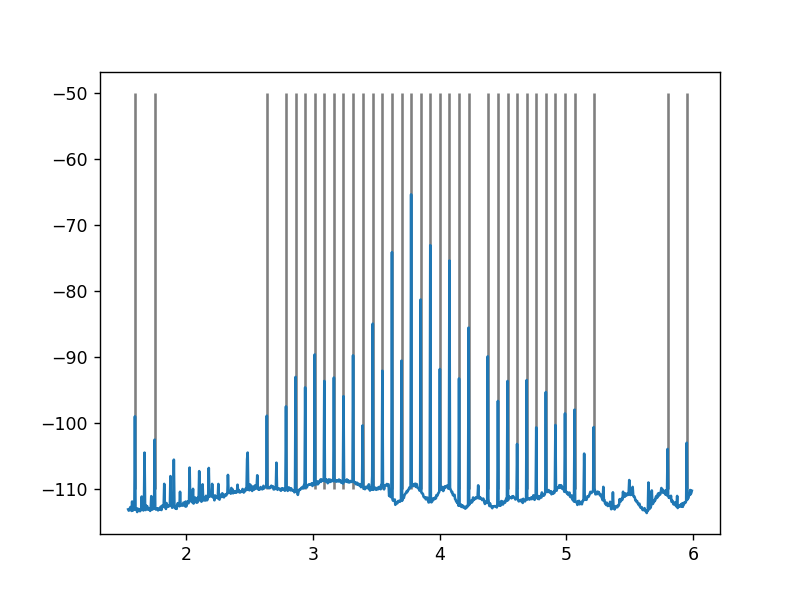

12
47
246
280
297
314
331
348
365
382
399
416
434
451
468
485
502
519
536
553
570
587
604
638
656
673
690
707
724
741
758
775
792
826
957
991


In [113]:
%matplotlib notebook
f_start = spec.query_ascii_values(':FREQ:START?')[0]
f_stop = spec.query_ascii_values(':FREQ:STOP?')[0]

f = np.linspace(f_start, f_stop, len(y))

plt.plot(f / 1e9, y)

plt.vlines(f[y > -104] / 1e9, -110, -50, alpha=0.5)
plt.show()

p = [139, 172, 199, 236, 280, 310, 344, 375, 412, 448]
f[y > -69]

for i, v in enumerate((y > -104)):
    if v:
        print(i)

In [11]:
def SNR():
    y = np.asarray(spec.query_ascii_values(':TRACe? TRACE1 '))
    #spectrum_density = 10**(y/10)
#     p = [500]
#     signal = 10*np.min([spectrum_density[i] for i in p])
    return 10*np.log10(signal/(np.sum(spectrum_density)-signal))

In [92]:
async def SNR(offset1,offset2):
    await awg.setValue('Offset',offset1,ch=3)
    await awg.setValue('Offset',offset2,ch=4)
    time.sleep(2)
    y = np.asarray(spec.query_ascii_values(':TRACe? TRACE1 '))
    return np.mean(y[498:502])

In [93]:
mr.Att_Setup('com12').Att(0)
opt.optimize(SNR,[0,0],[0.1,0.1],[3,3],high=[2,2],low=[-2,-2],print_info=True)

com12 open...
DS Instruments,DAT64H,396,V9.10
last ATT 00.0
now ATT 00.0
.o
[0. 0.] -7.195046544   ...o
[-0.1  0.1] -11.182996035   ..o
[-0.1  0. ] -12.6719770425   .o
[-0.15 -0.05] -13.8447523125   .o
[-0.25  0.05] -17.981342315   .....o
[-0.175  0.   ] -21.746237755000003   ..o
[-0.181  0.038] -22.798667430000002   ..o
[-0.214  0.034] -26.6131715775   ..o
[-0.186  0.018] -26.749501705   .o
[-0.219  0.015] -33.006567955   .....o
[-0.2    0.019] -34.868162155   .o
[-0.211  0.008] -36.14327717   ...o
[-0.212  0.014] -42.62541772   ..o
[-0.206  0.015] -48.198260174999994   ......o
[-0.207  0.014] -51.850216522500006   ..o
[-0.208  0.015] -63.107133860000005   ...................
 CacheInfo(hits=15, misses=43, maxsize=128, currsize=43)


 final_simplex: (array([[-0.20813344,  0.01503291],
       [-0.20821788,  0.01498535],
       [-0.20811348,  0.01498768]]), array([-63.10713386, -63.10713386, -63.10713386]))
           fun: -63.107133860000005
       message: 'Optimization terminated successfully.'
          nfev: 58
           nit: 26
        status: 0
       success: True
             x: array([-0.208,  0.015])

In [109]:
await awg.setValue('Offset',-0.208,ch=3)
await awg.setValue('Offset',0.015,ch=4)

In [102]:
async def modulation_read(angle,amp1,amp2):
    t_list = np.linspace(0,100000,250000)
    delta = [50e6]
    f, phi, t_end, width, height = [delta], [[angle]], [[100000]], [[100000]], [[amp1]]
    wf = WF(t_list)
#     await awg.create_waveform(name='Readout_Q', length=len(t_list), format=None)
#     await awg.create_waveform(name='Readout_I', length=len(t_list), format=None)
    sample = wf.square_envelope(f,phi,t_end,width,height)
    await awg.update_waveform(sample,name='Readout_Q')
    
    f, phi, t_end, width, height = [delta], [[np.pi/2]], [[100000]], [[100000]], [[amp2]]
    sample = wf.square_envelope(f,phi,t_end,width,height)
    await awg.update_waveform(sample,name='Readout_I')
    time.sleep(3)
#     sample = wf.square_wave(t_end=[91180],width=[1000],height=[1])
#     await awg.update_marker(name='Readout_Q',mk1=sample)
    await awg.query('*OPC?')

In [103]:
async def phaseSNR(phase,amp1,amp2):
    await modulation_read(phase,amp1,amp2)
    y = np.asarray(spec.query_ascii_values(':TRACe? TRACE1 '))
    return np.mean(y[548:552])

In [106]:
mr.Att_Setup('com12').Att(0)
opt.optimize(phaseSNR,[0,1,1],[np.pi/20,0.01,0.01],[5,3,3],high=[np.pi,1,1],low=[-np.pi,0,0],print_info=True)

com12 open...
DS Instruments,DAT64H,396,V9.10
last ATT 00.0
now ATT 00.0
.o
[0. 1. 1.] -28.1431055075   .o
[0.15708 1.      1.     ] -35.9303092975   ...........o
[0.14132 0.9975  0.9973 ] -36.304574967499995   .o
[0.15045 0.9971  1.     ] -36.5619859675   .....o
[0.14732 0.9927  1.     ] -37.4481363275   .o
[0.15603 0.9878  1.     ] -37.9695739725   ....o
[0.1474 0.9854 1.    ] -38.81052493999999   .o
[0.14587 0.9795  1.     ] -40.13726902   ..o
[0.15873 0.972   1.     ] -40.777949335   .o
[0.16105 0.9631  1.     ] -42.435783395   .o
[0.16015 0.9575  1.     ] -44.006894145   .o
[0.16221 0.9423  1.     ] -45.0604258275   .o
[0.14541 0.9479  1.     ] -56.528834275   .......o
[0.13494 0.9407  1.     ] -57.308092097499994   .....o
[0.13929 0.9475  1.     ] -61.761883955   ..o
[0.14311 0.945   1.     ] -63.78300173000001   ....o
[0.13824 0.9435  1.     ] -69.30427546749999   .o
[0.14312 0.9423  1.     ] -78.25378138250001   .................................................................


 final_simplex: (array([[0.14311904, 0.94225858, 1.00662614],
       [0.14312105, 0.9422556 , 1.00662801],
       [0.14311688, 0.94225756, 1.00662638],
       [0.14312267, 0.94225659, 1.00662856]]), array([-78.25378138, -78.25378138, -78.25378138, -78.25378138]))
           fun: -78.25378138250001
       message: 'Optimization terminated successfully.'
          nfev: 115
           nit: 52
        status: 0
       success: True
             x: array([0.14312, 0.9423 , 1.     ])

In [107]:
await modulation_read(0.14312, 0.9423 , 1.)

In [43]:

async def modulation_read(angle):
    t_list = np.linspace(0,100000,250000)
    delta = [50e6]
    f, phi, t_end, width, height = [delta], [[angle]], [[100000]], [[100000]], [[1]]
    wf = WF(t_list)
    await awg.create_waveform(name='Readout_Q', length=len(t_list), format=None)
    await awg.create_waveform(name='Readout_I', length=len(t_list), format=None)
    sample = wf.square_envelope(f,phi,t_end,width,height)
    await awg.update_waveform(sample,name='Readout_Q')
    
    f, phi, t_end, width, height = [delta], [[np.pi/2]], [[100000]], [[100000]], [[1]]
    sample = wf.square_envelope(f,phi,t_end,width,height)
    await awg.update_waveform(sample,name='Readout_I')
    
#     sample = wf.square_wave(t_end=[91180],width=[1000],height=[1])
#     await awg.update_marker(name='Readout_Q',mk1=sample)
    time.sleep(5)
    
    
async def setIQWaveform(awg, delta, phi):
    N = len(delta)
    wav1, wav2 = 0, 0
    for f, p0 in zip(delta, phi):
        wav1 += Cos(2*np.pi*f/1e9, p0)
        wav2 += Cos(2*np.pi*f/1e9, np.pi/2)
    wav1 /= N
    wav2 /= N
    wav1.set_range(0,100000)
    wav2.set_range(0,100000)
    data1 = wav1.generateData(2.5)
    data2 = wav2.generateData(2.5)
    
    await awg.update_waveform(data1, name='Readout_Q')
    await awg.update_waveform(data2, name='Readout_I')
    
    t_list = np.linspace(0,100000,250000)
    wf = WF(t_list)
    sample = wf.square_wave(t_end=[91180],width=[1000],height=[1])
    await awg.update_marker(name='Readout_Q',mk1=sample)
    time.sleep(5)

In [10]:
f_01 = np.array([3.795,3.817,3.894,3.774,3.906,3.775,3.885,3.788,3.890])*1e9
delta_01 = -(f_01 - 3.85e9)

In [11]:
delta_01

array([ 55000000.,  33000000., -44000000.,  76000000., -56000000.,
        75000000., -35000000.,  62000000., -40000000.])

In [109]:
await modulation_read(awg134,[76000000],[0])

In [29]:
from qulab.sugar import connect
from qulab.job import Job
from qulab.storage.utils import save
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple, deque, defaultdict, OrderedDict, Counter
from scipy.optimize import curve_fit, least_squares as ls
import time, asyncio, sys
from tqdm import tqdm_notebook as tqdm
from qulab.wavepoint import WAVE_FORM as WF
from qulab import optimize as op
from qulab.waveform import CosPulseDrag, Expi, DC, Step, Gaussian, Cos
from qulab.math.qst import transformList, acquireVFromData, vToRho

awg133 = await connect('AWG133')
psg_ex = await connect('PSG106')
awg132 = await connect('AWG132')
awg131 = await connect('AWG131')
awg134 = await connect('AWG134')

In [13]:
await awg134.create_waveform(name='Readout_Q', length=250000, format=None)
await awg134.create_waveform(name='Readout_I', length=250000, format=None)

In [14]:
await psg_ex.setValue('Frequency',3.85e9)

In [39]:
await awg132.use_waveform(name='Readout_I',ch=1)
await awg132.use_waveform(name='Readout_Q',ch=2)

In [41]:
await awg134.use_waveform(name='Readout_I',ch=1)
await awg134.use_waveform(name='Readout_Q',ch=5)

In [95]:
phi = np.array([-1.51, -1.62, -2.35, -3.83,  1.86,  1.5,   1.25,  0.8,   0.14,  0.28])
delta = np.zeros(10)
await modulation_read(awg134,delta,phi)

In [21]:
from qulab.math import optimize

In [50]:
await awg134.setValue('Offset',1,ch=1)

In [ ]:
async def 

In [32]:
help(optimize)

Help on function optimize in module qulab.math.opt:

optimize(target, start, senstive=None, dec=None, high=None, low=None, print_info=False)
    target: 目标函数
    start: 起始点
    senstive: list 敏感度
    dec: list 小数位数
    high: list 上限
    low: list 下限
    print_info: bool



In [90]:
async def target(*phi):
    await setIQWaveform(awg134, delta_01, phi)
    await asyncio.sleep(2)
    return SNR()


optimize(target, [0, 0, 0, 0, 0, 0, 0, 0, 0],
         senstive=[0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3],
         dec=[2, 2, 2, 2, 2, 2, 2, 2, 2],
         print_info=True)


.o
[0. 0. 0. 0. 0. 0. 0. 0. 0.] -0.5493684011602165   .o
[0.3 0.  0.  0.  0.  0.  0.  0.  0. ] -1.1462661786390105   ...o
[0.  0.  0.  0.3 0.  0.  0.  0.  0. ] -1.9392623515516094   .o
[0.  0.  0.  0.  0.3 0.  0.  0.  0. ] -1.9551767518992935   ..o
[0.  0.  0.  0.  0.  0.  0.3 0.  0. ] -3.067018788051366   .....o
[ 0.1  -0.08  0.1   0.1   0.1   0.1   0.1  -0.05  0.1 ] -9.032297987612422   ........................................................................................................................................................................................
 CacheInfo(hits=89, misses=108, maxsize=128, currsize=108)


 final_simplex: (array([[ 0.09958848, -0.08148148,  0.09958848,  0.09958848,  0.09958848,
         0.09958848,  0.09958848, -0.04855967,  0.09958848],
       [ 0.09957002, -0.08148882,  0.09960755,  0.09960754,  0.09957548,
         0.09957366,  0.09957252, -0.0485734 ,  0.09958014],
       [ 0.09962104, -0.08147905,  0.09958353,  0.09955806,  0.09958594,
         0.09955573,  0.09959095, -0.04857897,  0.09961481],
       [ 0.09959035, -0.08145817,  0.09956543,  0.09959541,  0.0995631 ,
         0.09956895,  0.09960363, -0.04858508,  0.09958156],
       [ 0.09958854, -0.08149953,  0.09957553,  0.09958469,  0.09958062,
         0.09955697,  0.09959528, -0.04855938,  0.09960357],
       [ 0.09956762, -0.0814784 ,  0.09960894,  0.09956341,  0.09957669,
         0.0995534 ,  0.09959687, -0.04857062,  0.09960654],
       [ 0.09958481, -0.08150179,  0.0995981 ,  0.09957423,  0.09956806,
         0.09958155,  0.09960557, -0.04857353,  0.0996065 ],
       [ 0.09958578, -0.08149031,  0.09959514

<IPython.core.display.Javascript object>


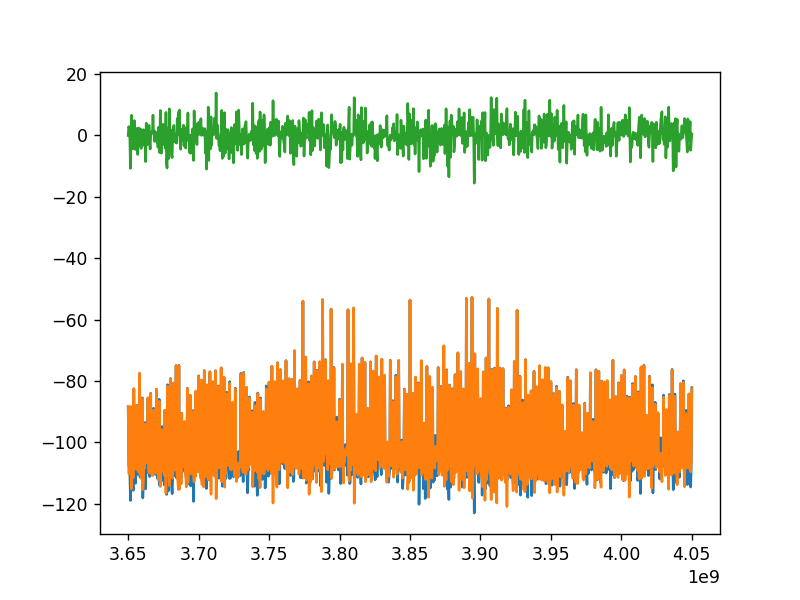

In [66]:
%matplotlib notebook
delta = delta_01
phi = np.zeros(1)-0.5*np.pi

await setIQWaveform(awg133,delta,phi)
time.sleep(2)

y1 = np.asarray(spec.query_ascii_values(':TRACe? TRACE1 '))
plt.plot(f,y1)

phi = np.zeros(1)+0.*np.pi
await setIQWaveform(awg133,delta,phi)

time.sleep(2)

y2 = np.asarray(spec.query_ascii_values(':TRACe? TRACE1 '))
plt.plot(f,y2)

plt.plot(f,y1-y2)

plt.show()

In [63]:
def IQWaveform(delta, phi):
    N = len(delta)
    wav1, wav2 = 0, 0
    for f, p0 in zip(delta, phi):
        wav1 += Cos(2*np.pi*f/1e9, p0)
        wav2 += Cos(2*np.pi*f/1e9, np.pi/2)
    wav1 /= N
    wav2 /= N
    wav1.set_range(0,100000)
    wav2.set_range(0,100000)
    data1 = wav1.generateData(2.5)
    data2 = wav2.generateData(2.5)
    return data1, data2

phi = np.zeros(1)-0*np.pi

d1, d2 = IQWaveform(delta,phi)
plt.plot(d1[:250])
plt.plot(d2[:250])

phi = np.zeros(1)+0.2*np.pi
d1, d2 = IQWaveform(delta,phi)
plt.plot(d1[:250])
plt.plot(d2[:250])

In [65]:
spec.query(':DISPlay:WINDow:TRACe:X:SPACing?')

'LIN\n'

<IPython.core.display.Javascript object>


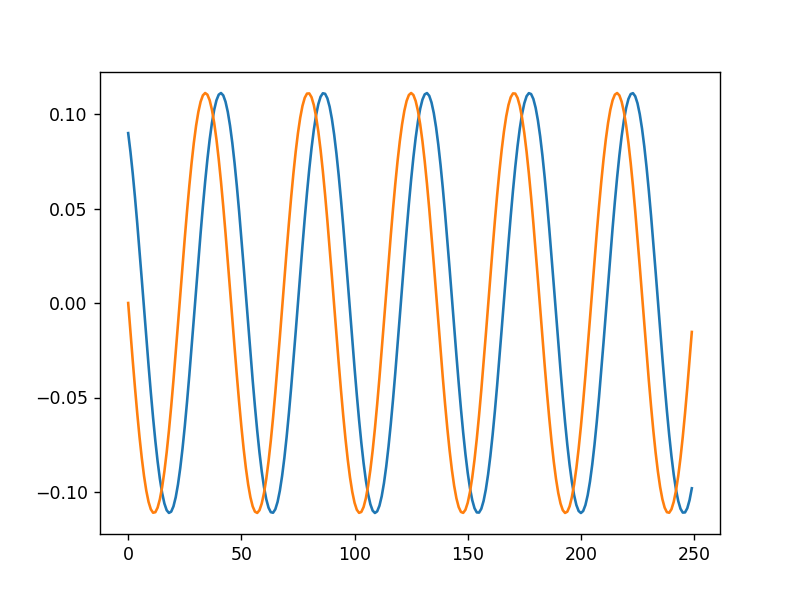

In [64]:
%matplotlib notebook
plt.plot(d1[:250])
plt.plot(d2[:250])